# Models

In [153]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.15)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.10f}'.format
plt.rcParams['figure.figsize'] = (8, 5)

In [3]:
#LOAD LOANSTATS
directory = '../../../data/'
ls = pd.read_hdf(directory + 'LS_CLEAN.h5', 'LS_CLEAN')
ls.sort_index(axis=1, inplace=True)

## 0. Preprocessing

### Train-Test Split

We split the `ls` dataset into a train and test part. We do this in a stratified fashion ensuring that the outcome classes (fully paid loans and not fully paid loans) are equally represented in each set. For the splitting algorithm, we use `sklearn`'s `train_test_split` function. This function creates random train and test subsets of the dataset. The flag `stratify` ensures that both classes are equally represented in each set. 

In [107]:
from sklearn.model_selection import train_test_split
ls_train, ls_test = train_test_split(ls, test_size=0.15, stratify=ls['OUT_Class'])

### Standard Scaling

The models used in the next sections assume that the features are on similar scales. To achieve this, we transform the numeric variables to a standard scale with mean 0 and standard deviation 1 using sklearn's `StandardScaler` function.

In [108]:
#IDENTIFY THE OUTCOME, DUMMY AND NUMERIC VARIABLES
var_list = set(ls.columns)
outcome_var_list = set(out_var for out_var in var_list if "OUT_" in out_var)
dummy_var_list = set(dummy for dummy in var_list if "D_" in dummy)
numeric_var_list = var_list - outcome_var_list - dummy_var_list

In [109]:
#STANDARD SCALER
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [110]:
#SCALE THE TRAINING SETS (fit_transform)
train_vars_scaled = pd.DataFrame(scaler.fit_transform(ls_train[list(numeric_var_list)]),
                                 index=ls_train.index, 
                                 columns=ls_train[list(numeric_var_list)].columns)
feature_train = pd.concat([train_vars_scaled, 
                           ls_train[list(dummy_var_list)]], 
                          axis=1).sort_index(axis=1)
outcome_train = ls_train[list(outcome_var_list)]

In [111]:
#STANDARDIZE THE TEST SET (transform)
test_vars_scaled = pd.DataFrame(scaler.transform(ls_test[list(numeric_var_list)]),
                                index=ls_test.index, 
                                columns=ls_test[list(numeric_var_list)].columns)
feature_test = pd.concat([test_vars_scaled, 
                          ls_test[list(dummy_var_list)]], 
                         axis=1).sort_index(axis=1)
outcome_test = ls_test[list(outcome_var_list)]

## 1. Logisitic Regression Classification

The first model is a logistic regression on the outcome variable `OUT_class` which is the binary classification for loans are either fully repaid (1) or charged off (0). The flag `class_weight='balanced'` ensures that both classes are equally represented in each set. 

In [112]:
#SET TARGET VARIABLE 'OUT_Class'
target_train = outcome_train.iloc[:,2]
target_test = outcome_test.iloc[:,2]

In [137]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, class_weight='balanced')
classifier.fit(feature_train, target_train)
target_predicted = classifier.predict(feature_test)
target_probabilities = classifier.predict_proba(feature_test)[:,1]

In [129]:
#MODEL EVALUATION
from sklearn.model_selection import cross_val_score

#ACCURACY
train_accuracy = classifier_model.score(feature_train, target_train)
print('Train Accuracy: {:.4}'.format(train_score))
test_accuracy = classifier_model.score(feature_test, target_test)
print('Test Accuracy: {:.4}'.format(test_score))
cross_val_accuracy = cross_val_score(classifier, feature_train, target_train, scoring='accuracy', cv=5).mean()
print('Cross-Validation Accuracy: {:.4}'.format(cross_val_accuracy))

#PRECISION: true good loans / total predicted good loans
precision = cross_val_score(classifier, feature_train, target_train, scoring='precision', cv=5).mean()
print('Precision: {:.4}'.format(precision))

#RECALL: true good loans / total actual good loans
recall = cross_val_score(classifier, feature_train, target_train, scoring='recall', cv=5).mean()
print('Recall: {:.4}'.format(recall))

Train Accuracy: 0.6342
Test Accuracy: 0.6361
Cross-Validation Accuracy: 0.6344
Precision: 0.9127
Recall: 0.6351


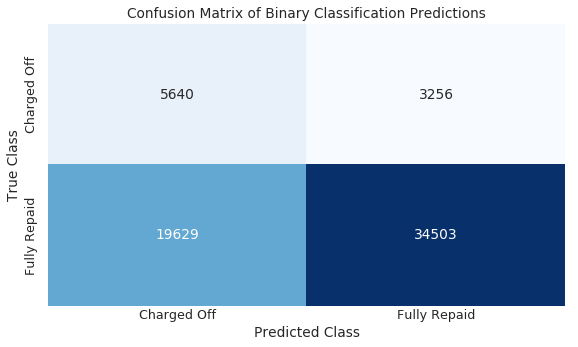

In [154]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

matrix = pd.DataFrame(confusion_matrix(target_test, target_predicted),
                      index=['Fully Repaid', 'Not Fully Repaid'],
                      columns=['Fully Repaid', 'Not Fully Repaid'])

fig, ax = plt.subplots()
sns.heatmap(matrix, annot=True, fmt='g', cbar=None, cmap='Blues')
plt.title('Confusion Matrix of Binary Classification Predictions')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
ax.set_xticklabels(['Charged Off', 'Fully Repaid'], va='center')
ax.set_yticklabels(['Charged Off', 'Fully Repaid'], va='center')
plt.show()

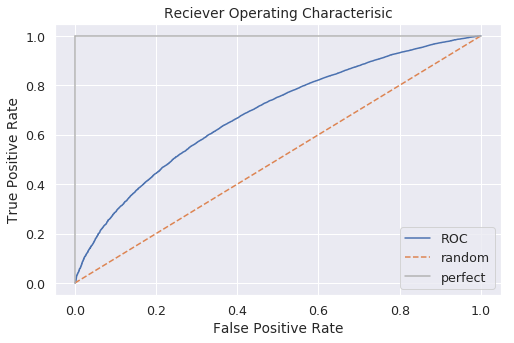

In [155]:
#ROC CURVE
from sklearn.metrics import roc_curve, roc_auc_score
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_probabilities)
plt.title('Reciever Operating Characterisic')
plt.plot(false_positive_rate, true_positive_rate, label='ROC')
plt.plot([0,1], ls='--',label='random')
plt.plot([0,0],[1,0], c='.7', )
plt.plot([1,1], c='.7', label='perfect')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Regression

## Trees and Forest

## K-Nearest Neighbors